In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Reshape, Layer
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from time import time
import random

In [65]:
loss_tracker = keras.metrics.Mean(name="loss")
class Replica(Sequential):
    @property
    def metrics(self):
        return [loss_tracker] #igual cambia el loss_tracker

    def train_step(self, data):
        batch_size =100 #Calibra la resolucion
        x = tf.random.uniform((batch_size,1), minval=-1, maxval=1)
        f = tf.math.cos(2*x)

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = tf.math.reduce_mean(tf.math.square(y_pred-f))

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        #actualiza metricas
        loss_tracker.update_state(loss)

        return {"loss": loss_tracker.result()}
    
class PolynomAdjust(tf.keras.layers.Layer):
    def __init__(self, num_outputs=3):
        super(PolynomAdjust, self).__init__()
        self.num_outputs = num_outputs

        self.freq = tf.range(0, self.num_outputs + 1)

        self.kernel = self.add_weight("kernel", shape=[self.num_outputs + 1])

    def call(self, inputs):
        x = tf.convert_to_tensor(inputs)
        if (inputs.shape == ()):
            inputs=(inputs,)
        elif (len(inputs.shape)==1):
            inputs=tf.expand_dims(inputs, axis=1)
        batch = tf.shape(inputs)[0]
        res = self.kernel[0] + self.kernel[1]*x + self.kernel[2]*x**2 + self.kernel[3]*x**3
        return tf.expand_dims(res, axis=1)


In [66]:
model = Replica()
model.add(PolynomAdjust())
model.build(input_shape=(1,))
model.summary()

Model: "replica_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 polynom_adjust_22 (PolynomA  (1, 1)                   4         
 djust)                                                          
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


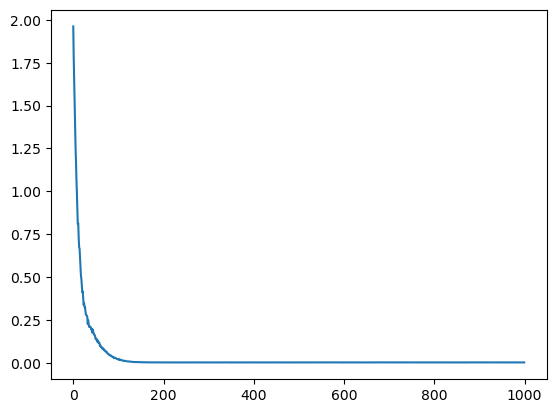

In [67]:
model.compile(optimizer=Adam(learning_rate=0.01), metrics=['loss'])
x=tf.linspace(-1, 1, 100)
history = model.fit(x, epochs=1000, verbose=0)
plt.plot(history.history["loss"])

4/4 [==============================] - 0s 1ms/step


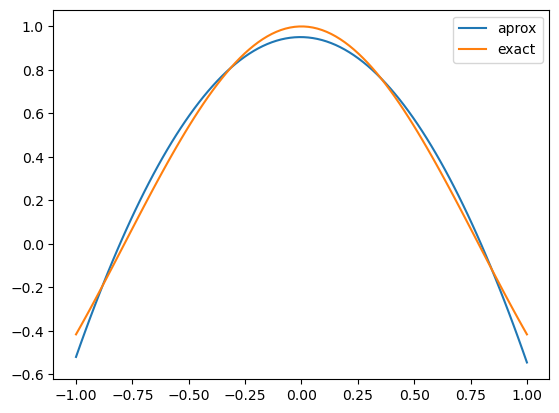

In [68]:
a=model.predict(x)
plt.plot(x, a, label="aprox")
plt.plot(x, tf.math.cos(2*x), label="exact")
plt.legend()
plt.show()